## Find out what par params best reproduce Pal 5 fan

In [15]:
from __future__ import division, print_function

# Third-party
import astropy.coordinates as coord
import astropy.units as u
import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np
#plt.style.use('apw-notebook')
%matplotlib inline

# Third-party
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
#import superfreq
#plt.style.use('apw-notebook')
%matplotlib inline

# Custom
import gala.coordinates as gc
import gala.dynamics as gd
from gala.dynamics.mockstream import fardal_stream, streakline_stream
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.util import rolling_window
from scipy.signal import argrelmin,argrelmax
from scipy.stats import scoreatpercentile
from scipy.integrate import quad
from matplotlib import cm
from tqdm import tqdm


import matplotlib as mpl
#x = gp.SphericalNFWPotential
#print(x)
#Data to see if stream matches observed quantities 
obs_oden = np.genfromtxt('/Users/spearson/Dropbox/Pal5Bar_copy/obs_RA.txt') 
OD = np.genfromtxt('/Users/spearson/Dropbox/Pal5Bar_copy/OD_radec.txt')

from potential import get_bar_model
from potential import default_mw

In [16]:
static_frame = gp.StaticFrame(units=galactic)

In [17]:
S = np.load('../data/Sn9l19m.npy') #expansion coeff.

# TODO: remove this line
S = S[:6, :8, :8]
S.size

384

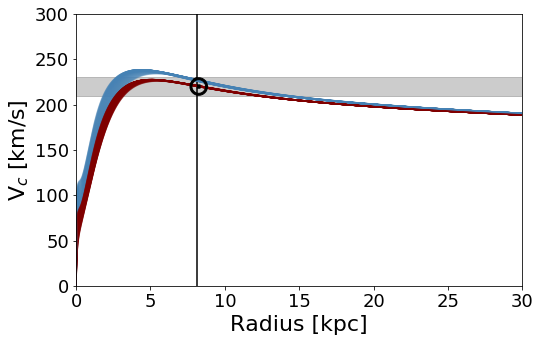

In [19]:

xyz = np.zeros((3, 1024)) + 1e-8
xyz[0] = np.linspace(0, 30, xyz.shape[1])
#potentials_m1e10[0]

####Plot something using this loop

plt.figure(figsize=(8, 5))
plt.xlim(0, 30)
plt.ylim(0, 300)

#Om = np.array([33,38,43,60])
Om = np.arange(25,65,1) #Array of pattern speeds, we are testing
mw = gp.BovyMWPotential2014()

for omega in Om*u.km/u.s/u.kpc:
    pot = gp.CCompositePotential()
    pot['disk'] = mw['disk']
    pot['halo'] = mw['halo']
    pot['bar'] = get_bar_model(Omega=omega, Snlm=S, m = 1e10)#, alpha=-27*u.deg) #set alpha 
    pot_m5e9 = gp.CCompositePotential()
    pot_m5e9['disk'] = mw['disk']
    pot_m5e9['halo'] = mw['halo']
    pot_m5e9['bar'] = get_bar_model(Omega=omega, Snlm=S, m = 5e9)
    #print(pot['bar'])
    
    plt.plot(xyz[0], pot.circular_velocity(xyz).to_value(u.km/u.s), color='steelblue', alpha=0.5)
    plt.plot(xyz[0], pot_m5e9.circular_velocity(xyz).to_value(u.km/u.s), color='maroon',alpha=0.5)
    plt.xlabel('Radius [kpc]')
    plt.ylabel('V$_c$ [km/s]')

plt.axhspan(210, 230, zorder=-100, alpha=0.2, color='black')
plt.axvline(8.1, zorder=-10, color='black')
plt.plot(8.1,220, marker='$\odot$', color='black', markersize=20)
#plt.title('$\Omega_b = 25-65$ km/s/kpc')
mpl.rcParams.update({'font.size': 22})
label_size = 18
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 
plt.savefig('v_circ_nlm919.png')

## Various potentials used
Loop over various pars with different $M$, $\Omega$, $r_s$

In [21]:
#get_bar_model(Omega=40*u.km/u.s/u.kpc, Snlm=S, m = 1e10)


In [22]:

#Om = np.array([33,38,43,60]) #already defined, checking whit more basis function coefficients 
#Om = np.arange(25,65,1) #Array of pattern speeds, we are testing
mw = gp.BovyMWPotential2014()
potentials_m1e10 = []
for omega in Om*u.km/u.s/u.kpc:
    pot = gp.CCompositePotential()
    pot['disk'] = mw['disk']
    pot['halo'] = mw['halo']
    pot['bar'] = get_bar_model(Omega=omega, Snlm=S, m = 1e10)#, alpha=-27*u.deg) #set alpha 
    #print(pot['bar'])
    frame = gp.ConstantRotatingFrame(Omega=[0,0,-1] * omega, units=galactic)
    H = gp.Hamiltonian(pot, frame) #frame such that we're "moving" with respect to bar
    potentials_m1e10.append(H)
len(potentials_m1e10)    

40

In [23]:
#get_bar_model(Omega=omega, Snlm=S, m = 1e10) #set it to what i want 

In [24]:
#pot['halo'].R

In [25]:
#np.arange(21,65,3) #next 27

In [26]:
# Also have a regular potential without bar
pot_nobar = mw


In [27]:
pot_flat = gp.CCompositePotential()
pot_flat['halo'] = gp.NFWPotential(m = mw['halo'].parameters['m'],
                                  r_s = mw['halo'].parameters['r_s'],
                                  c = 0.5, units=galactic)
pot_flat['disk'] = mw['disk']
pot_flat['bulge'] = mw['bulge']

pot_nobar_flat  = pot_flat

In [28]:
# Setting Sun's params - should update distance
v_lsr = [11.1, 24.0, 7.25]*u.km/u.s
v_circ = 220*u.km/u.s
galcen_frame = coord.Galactocentric(galcen_distance=8.*u.kpc)
sun_frame = dict(vlsr=v_lsr, vcirc=v_circ, galactocentric_frame=galcen_frame)

In [29]:
v_sun = coord.CartesianDifferential([11.1, 220 + 24.0, 7.25]*u.km/u.s)
galcen_frame = coord.Galactocentric(galcen_distance=8.*u.kpc,
                                    galcen_v_sun=v_sun)


pal5_c = coord.SkyCoord(ra=229.018*u.degree, dec=-0.124*u.degree,
                   distance=22.9*u.kpc,
                   pm_ra_cosdec=-2.296*u.mas/u.yr,
                   pm_dec=-2.257*u.mas/u.yr,
                   radial_velocity=-58.7*u.km/u.s)



w0 = gd.PhaseSpacePosition(pal5_c.transform_to(galcen_frame).cartesian)

In [30]:
n_steps=8000
forw_orbit = []#np.zeros([n_steps+1,len(pot)])
for i in range(len(potentials_m1e10)):
    orbit = potentials_m1e10[i].integrate_orbit(w0, dt=-0.5, n_steps=n_steps, Integrator=gi.DOPRI853Integrator)
    forw_orbit.append(orbit[::-1])

In [31]:
#ALSO DO IN NON-BARRED POT

orbit = pot_nobar.integrate_orbit(w0, dt=-0.5, n_steps=n_steps, Integrator=gi.DOPRI853Integrator)
forw_orbit_nobar = orbit[::-1]

In [32]:
## ALSO DO IN FLATTENED POTENTIAL
orbit = pot_nobar_flat.integrate_orbit(w0, dt=-0.5, n_steps=n_steps, Integrator=gi.DOPRI853Integrator)
forw_orbit_flat = orbit[::-1]

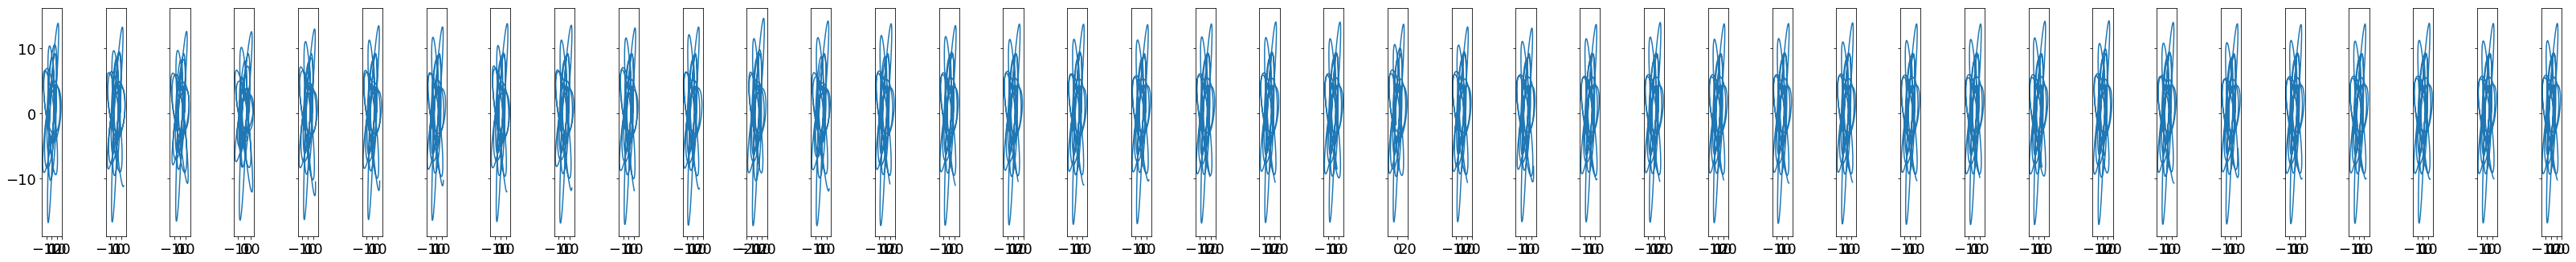

In [33]:
fig,axes = plt.subplots(1,len(potentials_m1e10),figsize=(45,5), sharey=True)
for i in range(len(potentials_m1e10)):
    orbit = forw_orbit[i].to_frame(static_frame)

   # mpl.rcParams.update({'font.size': 22})
    label_size = 18
    matplotlib.rcParams['xtick.labelsize'] = label_size 
    matplotlib.rcParams['ytick.labelsize'] = label_size 
  #  print(forw_orbit[i].x[0]) #check that orbits are slightly different 
    axes[i].plot(orbit.x, orbit.y)

    fig.tight_layout()
#fig.savefig('Fig1.pdf',dpi=400)

In [ ]:
stream = []
for i in tqdm(range(len(potentials_m1e10))):
    stream_data = gd.mockstream.fardal_stream(potentials_m1e10[i], forw_orbit[i], 5E4*u.Msun, release_every=10)
    
    stream.append(stream_data)

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
##ALSO IN NON-BARRED POT
stream_nobar = gd.mockstream.fardal_stream(pot_nobar, forw_orbit_nobar, 5E4*u.Msun, release_every=10)
#stream_nobar = gd.PhaseSpacePosition(stream_nobar.pos.transform(M.T), 
 #                                    vel=stream_nobar.vel)
sim_c_nobar = stream_nobar.to_coord_frame(coord.ICRS, galactocentric_frame=galcen_frame)

In [ ]:
##ALSO Flattened potential
stream_flat = gd.mockstream.fardal_stream(pot_nobar_flat, forw_orbit_flat, 5E4*u.Msun, release_every=10)
#stream_flat = gd.PhaseSpacePosition(stream_flat.pos.transform(M.T), 
 #                                    vel=stream_flat.vel)
sim_c_flat = stream_flat.to_coord_frame(coord.ICRS, galactocentric_frame=galcen_frame)

In [ ]:

fig,axes = plt.subplots(1,2,figsize=(14,7))
mpl.rcParams.update({'font.size': 20})
label_size = 20
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 
axes[0].scatter(sim_c_nobar.ra, sim_c_nobar.dec,s=0.5)
axes[0].set_xlim(270,200)
axes[0].set_ylim(-30,20)
axes[0].set_aspect('equal')
axes[0].set_xlabel('RA [deg]')
axes[0].set_ylabel('Dec [deg]')
axes[0].set_title('Regular orbit') #make sure I grab correct Om. 

axes[1].scatter(sim_c_flat.ra, sim_c_flat.dec,s=0.5)
axes[1].set_xlim(270,200)
axes[1].set_ylim(-30,20)
axes[1].set_aspect('equal')
axes[1].set_xlabel('RA [deg]')
axes[1].set_ylabel('Dec [deg]')
axes[1].set_title('Chaotic orbit') #make sure I grab correct Om. 
    
fig.tight_layout()
fig.savefig('/Users/spearson/Dropbox/AnaPal5/static.png')


In [ ]:
ra = []
dec = []
distance = []
pm_ra = []
pm_dec = []
vr = []
for i in range(len(potentials_m1e10)):
    sim_c = stream[i].to_coord_frame(coord.ICRS, galactocentric_frame=galcen_frame)
    ra.append(sim_c.ra)
    dec.append(sim_c.dec)
    distance.append(sim_c.distance)
    pm_ra.append(sim_c.pm_ra_cosdec)
    pm_dec.append(sim_c.pm_dec)
    vr.append(sim_c.radial_velocity)

## Look for length, leading fan, trailing gap

In [ ]:
# fig,axes = plt.subplots(len(potentials_m1e10),1,figsize=(10,10), sharex=True)
# axes[3].set_xlabel('RA [deg]')
# for i in range(len(potentials_m1e10)):

#     mpl.rcParams.update({'font.size': 10})
#     label_size = 10
#     matplotlib.rcParams['xtick.labelsize'] = label_size 
#     matplotlib.rcParams['ytick.labelsize'] = label_size 
#     axes[i].scatter(ra[i],dec[i] , s=0.5)
#     axes[i].set_xlim(250,215)
#     axes[i].set_ylabel('Dec [deg]')
#     axes[i].set_ylim(-10,10)
#     axes[i].set_aspect('equal')
    
#     axes[i].set_title('$\Omega_b = $ '+ str(np.int(Om[i])) + ' km / (kpc s)')

#     fig.tight_layout()
# #fig.savefig('bar.png',dpi=400)

## Save all snapshots to compare bar models

In [ ]:

for i in range(len(potentials_m1e10)):
    fig.clf()
    fig,axes = plt.subplots(1,figsize=(9,7), sharey=True)
    mpl.rcParams.update({'font.size': 20})
    label_size = 20
    matplotlib.rcParams['xtick.labelsize'] = label_size 
    matplotlib.rcParams['ytick.labelsize'] = label_size 
    axes.scatter(ra[i],dec[i] , s=0.5)
    axes.set_xlim(250,215)
    axes.set_ylim(-10,10)
    axes.set_aspect('equal')
    axes.set_xlabel('RA [deg]')
    axes.set_ylabel('Dec [deg]')
    axes.set_title('$\Omega_b$ = '+ str(Om[i]) + ' km / (kpc s)') #make sure I grab correct Om. 
    fig.savefig('/Users/spearson/Dropbox/AnaPal5/Pal5_morph_m1e10_rsfixed_Om_'+ str(Om[i]) + '.png')
    
    fig.tight_layout()
#fig.savefig('Fig1.pdf',dpi=400)

## Look at distance, radial velocity of each barred sim

In [ ]:

for i in range(len(potentials_m1e10)):
    fig.clf()
    fig,axes = plt.subplots(2,3,figsize=(14,7))
    mpl.rcParams.update({'font.size': 16})
    label_size = 16
    matplotlib.rcParams['xtick.labelsize'] = label_size 
    matplotlib.rcParams['ytick.labelsize'] = label_size 
    axes[0,0].scatter(ra[i],dec[i] , s=0.05, label='$\Omega_b$ = '+ str(Om[i]) + " km/s/kpc")
    axes[0,0].plot(OD[:,0], OD[:,1], marker='.', markersize=4, linestyle='none', color='black')
    axes[0,0].set_xlim(260,200)
    axes[0,0].set_ylim(-20,25)
    axes[0,0].set_aspect('equal')
    axes[0,0].set_xlabel('RA [deg]')
    axes[0,0].set_ylabel('Dec [deg]')
    axes[0,0].legend(loc="upper left", fontsize=10)
    
    axes[0,1].scatter(ra[i],distance[i] , s=0.05)
    axes[0,1].set_ylim(0,30)
    axes[0,1].set_xlim(260,200)
    #axes[0,1].set_aspect('equal')
    axes[0,1].set_xlabel('RA [deg]')
    axes[0,1].set_ylabel('Distance [kpc]')
    
    axes[0,2].scatter(ra[i],vr[i] , s=0.05)
    axes[0,2].plot(obs_oden[:,0],obs_oden[:,1],  marker='*', color='black', linestyle='none', label='Oden 09')
    axes[0,2].set_xlim(260,200)
    axes[0,2].set_ylim(-100,0)
    #axes[0,1].set_aspect('equal')
    axes[0,2].set_xlabel('RA [deg]')
    axes[0,2].set_ylabel('$v_r$ [km/s]')
    axes[0,2].legend(loc='lower right', fontsize=10)
    
    
    axes[1,1].scatter(ra[i],pm_ra[i] , s=0.05)
    axes[1,1].set_xlim(260,200)
    axes[1,1].set_ylim(-6,-1)
    axes[1,1].set_xlabel('RA [deg]')
    axes[1,1].set_ylabel('$pm_{ra}$ [mas/yr]')
    
    
    axes[1,2].scatter(ra[i],pm_dec[i] , s=0.05)
    axes[1,2].set_xlim(260,200)
    axes[1,2].set_ylim(-6,-1)
    axes[1,2].set_xlabel('RA [deg]')
    axes[1,2].set_ylabel('$pm_{dec}$ [mas/yr]')
    
    axes[1,0].axis('off')
 

    #fig.set_title('$\Omega_b$ = '+ str(Om), fontsize=24)#, y=1.03)
    #fig.suptitle('$\Omega_b$ = '+ str(Om), fontsize=24, y=1.03)
    fig.tight_layout()
    fig.savefig('/Users/spearson/Dropbox/AnaPal5/Pal5_vel_m1e10_rs_fixed_Om_{:02d}.png'.format(int(Om[i])))
 


In [ ]:

from scipy.integrate import simps

def density_on_grid(density, grid_lim=(-10, 10), ngrid=128):
    if isinstance(ngrid, int):
        ngrids = [ngrid]*3
    else:
        ngrids = ngrid
    grids = [np.linspace(grid_lim[0], grid_lim[1], ngrids[i])
             for i in range(3)]
    xyz = np.vstack(map(np.ravel, np.meshgrid(*grids)))

    val = np.zeros((np.prod(ngrids),))
    val = density(xyz).value
    val[np.isnan(val)] = val[np.isfinite(val)].max()
    
    gridx = xyz[0].reshape(*ngrids)[:,:,0]
    gridy = xyz[1].reshape(*ngrids)[:,:,0]
    
    return gridx, gridy, val

def surface_density(density, grid_lim=(-10, 10), ngrid=128):
    if isinstance(ngrid, int):
        ngrids = [ngrid]*3
    else:
        ngrids = ngrid
    xx, yy, dens3d = density_on_grid(density, ngrid=ngrids, 
                                     grid_lim=grid_lim)
    dens3d = dens3d.reshape(*ngrids)
    
    # Used for integration:
    _x = np.linspace(grid_lim[0], grid_lim[1], ngrids[2])
    return xx, yy, simps(dens3d, x=_x, axis=2)


In [ ]:
#get_bar_model(Omega=omega, Snlm=S, m = 1e10)
pattern_speeds = np.array([25,35,45,55,65])
potentials = []

for i in range(len(pattern_speeds)):
    diskbar = gp.CCompositePotential()
    diskbar['disk'] = mw['disk']
    diskbar['bar'] =  get_bar_model(Omega=pattern_speeds[i]*u.km/u.s/u.kpc, Snlm=S, m = 5e9)
    potentials.append(diskbar)

In [ ]:
xg = np.zeros([64,64,len(pattern_speeds)])
yg = np.zeros([64,64,len(pattern_speeds)])
surf_dens = np.zeros([64,64,len(pattern_speeds)])

for i in range(len(pattern_speeds)):
    xg[:,:,i], yg[:,:,i], surf_dens[:,:,i] = surface_density(potentials[i].density, 
                                    grid_lim=(-15, 15), 
                                    ngrid=[64, 64, 24])


In [ ]:
#pot['bar']

In [ ]:
# xg, yg, surf_dens = surface_density(diskbar.density, 
#                                     grid_lim=(-15, 15), 
#                                     ngrid=[64, 64, 24])

In [ ]:
fig, ax = plt.subplots(1, len(pattern_speeds), figsize=(5*len(pattern_speeds), 6))

for i in range(len(pattern_speeds)):
    ax[i].pcolormesh(xg[:,:,i], yg[:,:,i], surf_dens[:,:,i], 
              norm=mpl.colors.LogNorm())
    ax[i].set_title('$\Omega_b$ = ' + str(pattern_speeds[i]) + ' km/s/kpc')
    ax[i].set_xlim([-15,15])
    ax[i].set_ylim([-15,15])
    
#plt.savefig('bar_test.png')